In [1]:
HEIGHT = 4 # Height is from 1 ~ 4
WINSIZE = 10 # we can set 
LINES = 1000 # 用前1000行数据

In [2]:
"""
@Time    :2020/1/9 19:20
@Author  : 梁家熙
@Email:  :11849322@mail.sustech.edu.cn
"""
import json
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

from fastai import *
from fastai.vision import *
torch.cuda.set_device(1)

torch.multiprocessing.set_sharing_strategy('file_system')
class ImgSeq(ItemBase):
    def __init__(self, imgs):
        assert len(imgs.shape) == 4
        self.imgs = imgs

    def __str__(self):
        return str(self.imgs.shape)
    @property
    def data(self):
        return self.imgs

# 为了并行加速而使用的函数
def func(o, i, height):
    data = [int(x) for x in o.split(',')[-1].split(' ')]
    if len(data) != 60 * 101 * 101: return None

    t_pic = []
    for ind in range(height, 60, 4):
        sta = ind * 101 * 101
        end = sta + 101 * 101
        pic = data[sta: end]
        pic = torch.FloatTensor(pic).view(1, 101, 101)
        t_pic.append(pic)
    t_pic = torch.stack(t_pic)
    assert len(t_pic.shape) == 4
    return t_pic

# 为了并行加速
def load_from_file(pth, height = 4):
    assert 1<=height<=4
    height -= 1
    with open(pth) as f:
        lines = f.readlines()[:LINES]
    ret = parallel(partial(func, height = height), lines)
    print(f"{len(ret)}")
    ret = [w for w in ret if w is not None]
    print(f'{len(ret)}')
    return torch.stack(ret)

def generate_win(data, winsize):
    for i in range(len(data) - winsize + 1):
        yield data[i: i + winsize]

class ImageSeqList(ItemList):

    def __init__(self, items, *args, **kwargs):
        super(ImageSeqList, self).__init__(items)

    @classmethod
    def from_file(cls, file, height = 4, winsize = 10):
        data = load_from_file(file, height)
        assert len(data.shape) == 5 # datalen, seqlen, channel, imgsize. imgsize
        items = []
        for d in data:
            for img in generate_win(d, winsize = winsize):
                assert len(img.shape) == 4
                img = img / 255
                items.append(ImgSeq(img))
        return cls(items)

    def reconstruct(self, t:Tensor, x:Tensor=None):
        # ret = []
        # for w in t:
        #     a = torch.ones((1,101,1))
        #     w = torch.cat([w, a], -1)
        #     ret.append(w)
        # ret = torch.cat(ret, -1)
        # return Image(ret)
        return Image(torch.cat([w for w in t], -1))

    def show_xys(self, xs, ys, imgsize: int = 4, figsize: Optional[Tuple[int, int]] = None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = len(xs)

        axs = subplots(rows, 2, imgsize=imgsize, figsize=figsize)
        for i in range(0, len(axs.flatten()), 2):
            ax = axs.flatten()[i]
            index = i // 2
            x = xs[index]
            y = ys[index]
            x.show(ax=ax, **kwargs)
            y.show(ax=axs.flatten()[i + 1], **kwargs)
        #         for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize: int = 4, figsize: Optional[Tuple[int, int]] = None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x, y, z, ax in zip(xs, ys, zs, axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
                z._px = z._px.unsqueeze(0).float()
                y._px = y._px.float()
                x.show(ax=axs[i, 0], y=y, **kwargs)
                x.show(ax=axs[i, 1], y=z, **kwargs)

def label_func(input):
    y = input.imgs[1:, ... ]
    input.imgs = input.imgs[:-1, ...] # modify
    assert torch.equal(y[:-1, ...], input.imgs[1:, ...])
    return y

def collate(samples):
    batch_x, batch_y = zip(*samples)
    batch_x = torch.stack([w.data for w in batch_x])
    batch_y = torch.stack([w.data for w in batch_y])
    assert torch.equal(batch_x[:, 1:, ...], batch_y[:, :-1, ...])
    return batch_x, batch_y

databunch 的 pin_memory设置为True，数据则会同时放入GPU中，这样数据量一大，就会出out of memory （？？？？）

In [3]:
BATCHSIZE = 8
data_pth = Path('./data_new/CIKM2017_train/train.txt')
data = ImageSeqList.from_file(data_pth, height=HEIGHT, winsize=WINSIZE) # construct MyImageList which contains itembase
data = data.split_by_rand_pct(0.15) # ItemLists which contains trains and valids
data = data.label_from_func(label_func, label_cls = ImageSeqList)
data = data.databunch(bs = BATCHSIZE, collate_fn = collate, pin_memory = False, device = torch.device('cpu')) # to debug, we set

1000
1000


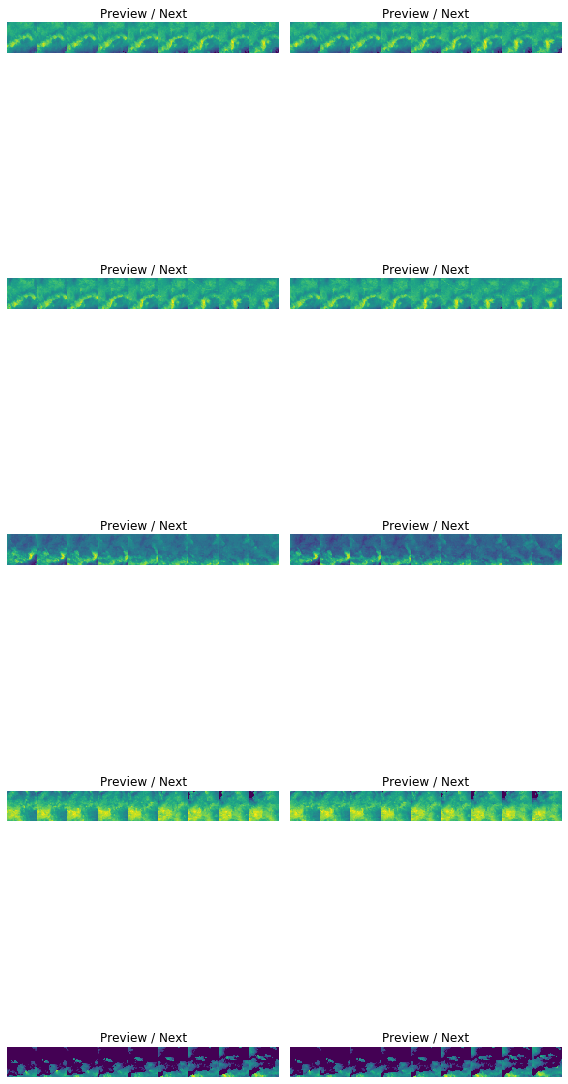

In [4]:
data.show_batch(title = "Preview / Next")

In [5]:
from convlstm import *
def get_model():
    encoder = ConvLSTM(input_size=(101, 101),
                 input_dim=1,
                 hidden_dim=[64, 64, 1],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

    model = Encorder(encoder)
    return model

def loss_func(x, y):

    x = x.view(-1).float()
    y = y.view(-1).float()
    assert len(x) == len(y), f'{len(x)} {len(y)}'
    y = y.to(x.device)
    return F.mse_loss(x, y)

model = get_model()


In [6]:
learner = Learner(data, model, loss_func = loss_func)
learner.summary()

Encorder
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [256, 101, 101]      150,016    True      
______________________________________________________________________
Conv2d               [256, 101, 101]      295,168    True      
______________________________________________________________________
Conv2d               [4, 101, 101]        2,344      True      
______________________________________________________________________

Total params: 447,528
Total trainable params: 447,528
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : function
Callbacks functions applied 

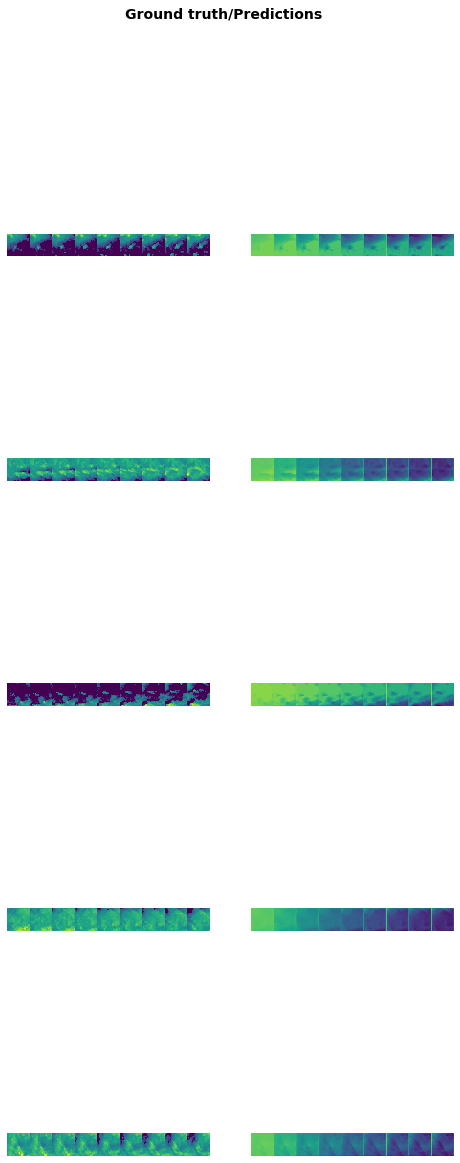

In [7]:
learner.show_results()

In [8]:
gc.collect()

21201

In [9]:
learner.model.cuda(1)

Encorder(
  (encoder): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(65, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)

In [10]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.74E-02


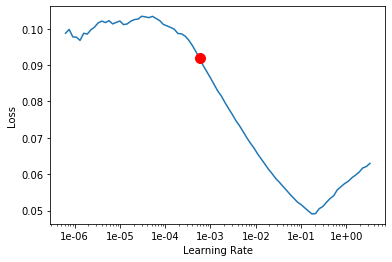

In [11]:
learner.recorder.plot(suggestion=True)

In [12]:
learner.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,time
0,0.002503,0.002492,25:56


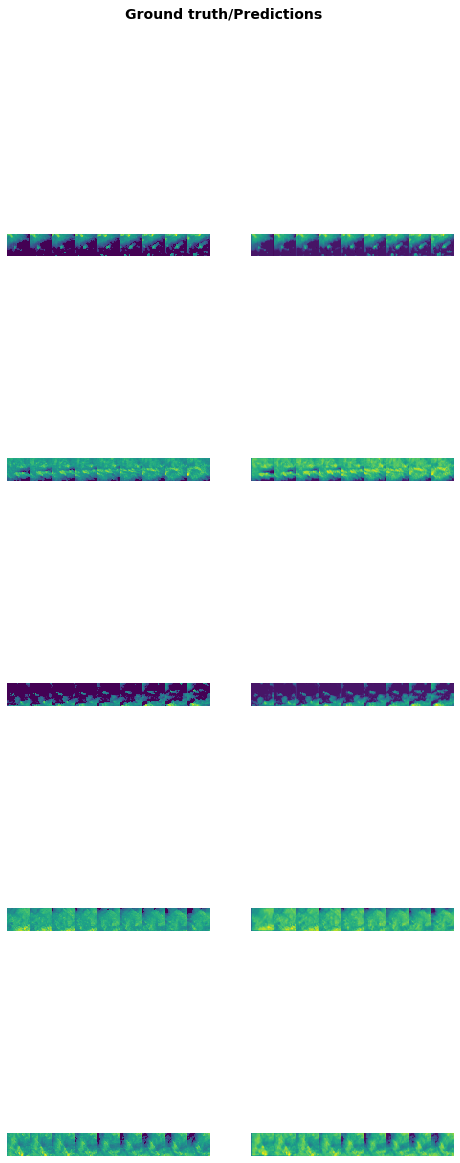

In [13]:
learner.show_results()

In [ ]:
learner.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,time
